# MSR + BRISQUE & NIQE Demo

Notebook ini berisi implementasi lengkap:
- Preprocessing citra (resize + denoising)
- Multi-Scale Retinex (MSR)
- Evaluasi kualitas citra dengan BRISQUE dan NIQE (no-reference IQA)

Silakan sesuaikan path folder dataset dan parameter sesuai kebutuhan.

In [1]:
import os
from pathlib import Path

import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import piq         
import pyiqa       

c:\Users\albia\anaconda3\envs\torch_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# -------------------------------------------------------------------
# 1. Setup device
# -------------------------------------------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)


Using device: cuda


In [3]:
# -------------------------------------------------------------------
# 2. Helper: konversi BGR (OpenCV) -> tensor PyTorch
# -------------------------------------------------------------------
def img_bgr_to_tensor(img_bgr: np.ndarray, device: torch.device = device) -> torch.Tensor:
    """
    img_bgr: numpy array (H, W, 3), BGR, uint8 (0–255) dari cv2.imread
    return : torch tensor (1, 3, H, W), RGB, float32, [0, 1] di device yang dipilih
    """
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_rgb = img_rgb.astype(np.float32) / 255.0
    t = torch.from_numpy(img_rgb).permute(2, 0, 1).unsqueeze(0).to(device)
    return t

In [4]:
# -------------------------------------------------------------------
# 3. Metric: BRISQUE & NIQE dari pyiqa
# -------------------------------------------------------------------
niqe_metric    = pyiqa.create_metric('niqe', device=device)
brisque_metric = pyiqa.create_metric('brisque', device=device)

def compute_niqe(img_bgr: np.ndarray) -> float:
    """Hitung NIQE no-reference dengan pyiqa dari gambar BGR (cv2)."""
    img_t = img_bgr_to_tensor(img_bgr, device)
    with torch.no_grad():
        score = niqe_metric(img_t)
    return float(score.item())

def compute_brisque(img_bgr: np.ndarray) -> float:
    """Hitung BRISQUE no-reference dengan pyiqa dari gambar BGR (cv2)."""
    img_t = img_bgr_to_tensor(img_bgr, device)
    with torch.no_grad():
        score = brisque_metric(img_t)
    return float(score.item())

Downloading: "https://huggingface.co/chaofengc/IQA-PyTorch-Weights/resolve/main/niqe_modelparameters.mat" to C:\Users\albia\.cache\torch\hub\pyiqa\niqe_modelparameters.mat



100%|██████████| 8.15k/8.15k [00:00<?, ?B/s]


Downloading: "https://huggingface.co/chaofengc/IQA-PyTorch-Weights/resolve/main/brisque_svm_weights.pth" to C:\Users\albia\.cache\torch\hub\pyiqa\brisque_svm_weights.pth



100%|██████████| 112k/112k [00:00<00:00, 2.12MB/s]


In [5]:
# -------------------------------------------------------------------
# 4. Simple color balance (opsional tapi hasil visual jauh lebih bagus)
# -------------------------------------------------------------------
def simple_color_balance(img_bgr: np.ndarray,
                         low_clip: float = 1,
                         high_clip: float = 99) -> np.ndarray:
    """
    Color balance sederhana per channel berdasarkan percentile.
    low_clip, high_clip: persen (0–100), misal 1 dan 99.
    """
    result = np.zeros_like(img_bgr, dtype=np.float32)
    for ch in range(3):
        channel = img_bgr[:, :, ch].astype(np.float32)
        lo = np.percentile(channel, low_clip)
        hi = np.percentile(channel, high_clip)
        if hi <= lo:
            # kalau percentilenya aneh, skip normalisasi channel ini
            result[:, :, ch] = channel
            continue
        ch_clip = np.clip(channel, lo, hi)
        ch_norm = (ch_clip - lo) / (hi - lo)
        result[:, :, ch] = ch_norm * 255.0

    return result.clip(0, 255).astype(np.uint8)

In [6]:
# -------------------------------------------------------------------
# 5. Multi-Scale Retinex (MSR)
# -------------------------------------------------------------------
def single_scale_retinex(channel: np.ndarray, sigma: float) -> np.ndarray:
    """
    Retinex skala tunggal untuk satu channel (float32).
    channel: (H, W) float32, nilai > 0
    sigma  : standar deviasi Gaussian blur
    """
    # Gaussian blur
    blurred = cv2.GaussianBlur(channel, (0, 0), sigma)
    # hindari log(0)
    eps = 1e-6
    retinex = np.log10(channel + eps) - np.log10(blurred + eps)
    return retinex

def multi_scale_retinex(img_bgr: np.ndarray,
                        scales=(15, 80, 250),
                        apply_color_balance: bool = True) -> np.ndarray:
    """
    Terapkan Multi-Scale Retinex ke gambar BGR uint8.

    scales: tuple/list sigma Gaussian (misal 3 skala)
    apply_color_balance: jika True, lakukan simple color balance setelah MSR
    """
    # konversi ke float32 dan geser sedikit supaya > 0
    img = img_bgr.astype(np.float32) + 1.0

    h, w, c = img.shape
    msr = np.zeros_like(img, dtype=np.float32)

    # proses per channel
    for ch in range(3):
        channel = img[:, :, ch]
        retinex_sum = np.zeros_like(channel, dtype=np.float32)
        for sigma in scales:
            retinex_sum += single_scale_retinex(channel, sigma)
        retinex_mean = retinex_sum / len(scales)
        msr[:, :, ch] = retinex_mean

    # normalisasi per channel ke [0, 255]
    for ch in range(3):
        ch_data = msr[:, :, ch]
        ch_min, ch_max = ch_data.min(), ch_data.max()
        if ch_max > ch_min:
            ch_norm = (ch_data - ch_min) / (ch_max - ch_min)
        else:
            ch_norm = np.zeros_like(ch_data)
        msr[:, :, ch] = ch_norm * 255.0

    msr_uint8 = msr.clip(0, 255).astype(np.uint8)

    if apply_color_balance:
        msr_uint8 = simple_color_balance(msr_uint8, low_clip=1, high_clip=99)

    return msr_uint8


In [11]:
# -------------------------------------------------------------------
# 6. Contoh end-to-end: baca gambar, MSR, hitung BRISQUE & NIQE
# -------------------------------------------------------------------
import time

# Path Gambar
img_path = "contohRemang.png"

if not os.path.exists(img_path):
    raise FileNotFoundError(f"Gambar tidak ditemukan: {img_path}")

# baca gambar (BGR)
img_orig = cv2.imread(img_path, cv2.IMREAD_COLOR)

# ----------------- Test Timing -----------------
t0 = time.time()

# MSR
img_msr = multi_scale_retinex(img_orig, scales=(15, 80, 250), apply_color_balance=True)
t1 = time.time()

# NIQE original
niqe_orig = compute_niqe(img_orig)
t2 = time.time()

# BRISQUE original
brisque_orig = compute_brisque(img_orig)
t3 = time.time()

# NIQE MSR
niqe_msr = compute_niqe(img_msr)
t4 = time.time()

# BRISQUE MSR
brisque_msr = compute_brisque(img_msr)
t5 = time.time()

# Cetak waktu
print("MSR               :", t1 - t0, "detik")
print("NIQE  original    :", t2 - t1, "detik")
print("BRISQUE original  :", t3 - t2, "detik")
print("NIQE  MSR         :", t4 - t3, "detik")
print("BRISQUE MSR       :", t5 - t4, "detik")
print("TOTAL             :", t5 - t0, "detik")

# ----------------- Cetak kualitas -----------------
print("\n=== Quality scores ===")
print(f"Original - NIQE   : {niqe_orig:.4f}")
print(f"Original - BRISQUE: {brisque_orig:.4f}")
print(f"MSR      - NIQE   : {niqe_msr:.4f}")
print(f"MSR      - BRISQUE: {brisque_msr:.4f}")


MSR               : 68.93380284309387 detik
NIQE  original    : 0.6316211223602295 detik
BRISQUE original  : 0.20905375480651855 detik
NIQE  MSR         : 0.3466300964355469 detik
BRISQUE MSR       : 0.20821285247802734 detik
TOTAL             : 70.3293206691742 detik

=== Quality scores ===
Original - NIQE   : 3.2812
Original - BRISQUE: -9.3642
MSR      - NIQE   : 2.4934
MSR      - BRISQUE: 2.8476


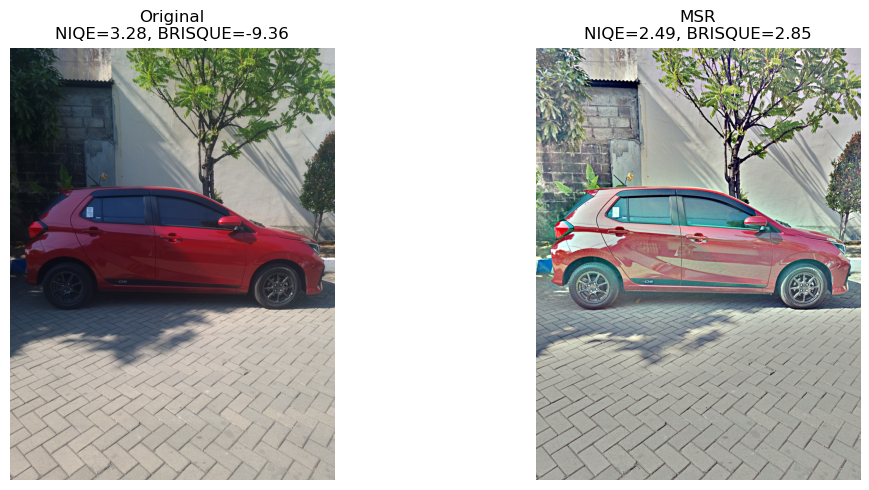

In [12]:
# -------------------------------------------------------------------
# 7. Visualisasi: sebelum vs sesudah MSR
# -------------------------------------------------------------------
# cv2 -> RGB untuk display di matplotlib
img_orig_rgb = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
img_msr_rgb  = cv2.cvtColor(img_msr,  cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(img_orig_rgb)
plt.title(f"Original\nNIQE={niqe_orig:.2f}, BRISQUE={brisque_orig:.2f}")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(img_msr_rgb)
plt.title(f"MSR\nNIQE={niqe_msr:.2f}, BRISQUE={brisque_msr:.2f}")
plt.axis("off")

plt.tight_layout()
plt.show()